<a href="https://colab.research.google.com/github/NamanChaudhary1/DeepLearning/blob/main/DeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()


Saving Brain_Data_Organised-20241125T091520Z-001.zip to Brain_Data_Organised-20241125T091520Z-001.zip


In [5]:
import zipfile
import os

# Replace 'brain_dataset.zip' with the name of your ZIP file
zip_file = 'Brain_Data_Organised-20241125T091520Z-001.zip'  # Adjust this if your file name is different

# Extract the ZIP file to a folder
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall('/content/brain_dataset')

print("Dataset extracted successfully!")


Dataset extracted successfully!


In [8]:
import shutil

# Create the necessary directories
os.makedirs('/content/brain_dataset/train/stroke', exist_ok=True)
os.makedirs('/content/brain_dataset/train/normal', exist_ok=True)

# Move the files into their respective directories
for filename in os.listdir('/content/brain_dataset/Brain_Data_Organised/Stroke'):
    shutil.move(f'/content/brain_dataset/Brain_Data_Organised/Stroke/{filename}', f'/content/brain_dataset/train/stroke/{filename}')

for filename in os.listdir('/content/brain_dataset/Brain_Data_Organised/Normal'):
    shutil.move(f'/content/brain_dataset/Brain_Data_Organised/Normal/{filename}', f'/content/brain_dataset/train/normal/{filename}')

print("Dataset organized!")


Dataset organized!


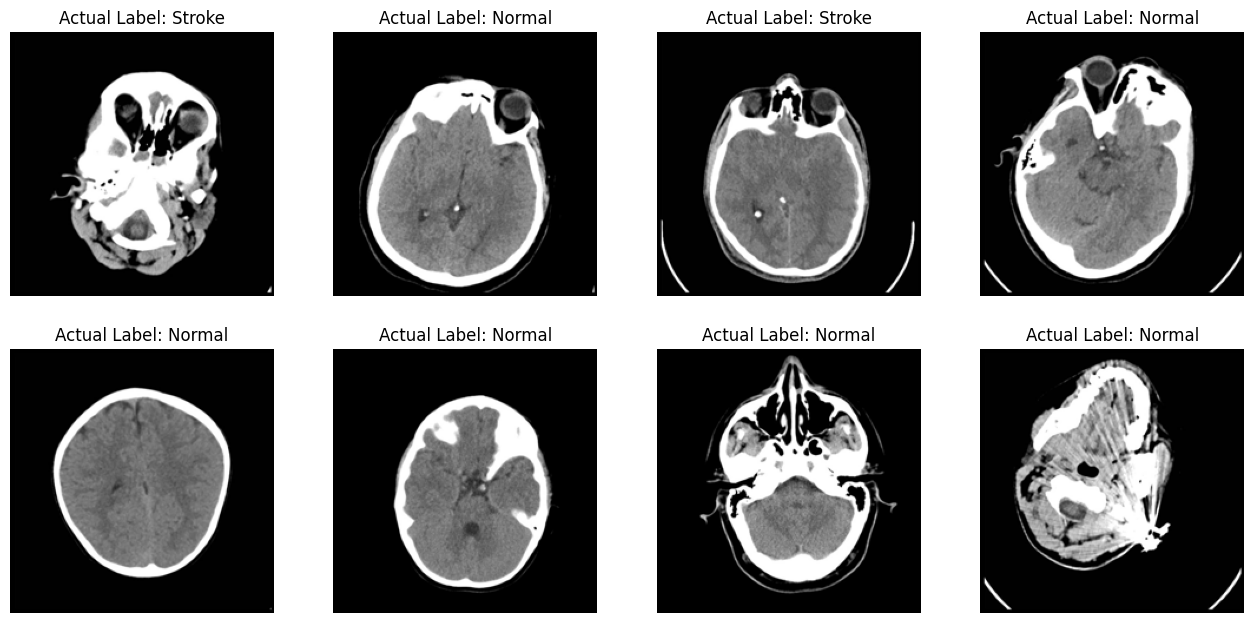

Epoch 1/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 334s 5s/step - accuracy: 0.5617 - loss: 0.9140 - val_accuracy: 0.6522 - val_loss: 0.6269
Epoch 2/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 367s 4s/step - accuracy: 0.6805 - loss: 0.6005 - val_accuracy: 0.6285 - val_loss: 0.6772
Epoch 3/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 318s 4s/step - accuracy: 0.6703 - loss: 0.6059 - val_accuracy: 0.6838 - val_loss: 0.6150
Epoch 4/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 314s 4s/step - accuracy: 0.7091 - loss: 0.5686 - val_accuracy: 0.6838 - val_loss: 0.6073
Epoch 5/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 322s 4s/step - accuracy: 0.7207 - loss: 0.5456 - val_accuracy: 0.6917 - val_loss: 0.5722
Epoch 1/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 322s 4s/step - accuracy: 0.6971 - loss: 0.5778 - val_accuracy: 0.6759 - val_loss: 0.5985
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 331s 5s/step - accuracy: 0.7205 - loss: 0.5462 - val_accuracy: 0.6364 - val_loss: 0.6602
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 308s 4s/step - accuracy: 0.7448 - loss: 0.5295 - val_accuracy: 0.6798 - val_lo

In [24]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Pre-processing function for images
def pre_processing(file_path_list):
    data = []

    for file_path in file_path_list:
        image = Image.open(file_path)
        image = image.resize((224, 224))  # Resize to 224x224 as InceptionV3 uses this size
        image = image.convert('RGB')  # Convert to RGB if not already
        image = np.array(image)  # Convert to numpy array
        data.append(image)

    return data

normal_path = '/content/brain_dataset/train/normal'
stroke_path = '/content/brain_dataset/train/stroke'

# Get file paths
normal = [os.path.join(normal_path, filename) for filename in os.listdir(normal_path)]
stroke = [os.path.join(stroke_path, filename) for filename in os.listdir(stroke_path)]

# Pre-process images
normal_array = pre_processing(normal)
stroke_array = pre_processing(stroke)

# Combine data
data = normal_array + stroke_array
data = np.array(data)

# Normal and stroke labels
normal_label = [0]*len(normal)  # Label 0 for normal
stroke_label = [1]*len(stroke)  # Label 1 for stroke
labels = normal_label + stroke_label
labels = np.array(labels)

# Split the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.10, shuffle=True)

# Display sample images
class_labels = ["Normal", "Stroke"]
plt.figure(figsize=(16, 24))
for i in range(8):
    plt.subplot(6, 4, i + 1)
    plt.imshow(x_train[i])
    plt.title(f"Actual Label: {class_labels[y_train[i]]}")
    plt.axis("off")
plt.show()

# Normalize the data (rescale pixel values)
x_train = x_train / 255.0
x_test = x_test / 255.0

# Initialize the InceptionV3 model without the top layers (as we will add our custom classifier)
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

# Train the model
history = model.fit(x_train, y_train, epochs=5, batch_size=32, validation_data=(x_test, y_test))

# Unfreeze the top layers for fine-tuning
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Recompile the model
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

# Continue training the model with fine-tuning
history_fine_tune = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test))

# Save the model
model.save("/content/brain_stroke_model.h5")



8/8 ━━━━━━━━━━━━━━━━━━━━ 31s 4s/step - accuracy: 0.7423 - loss: 0.4895
Test Accuracy: 0.72


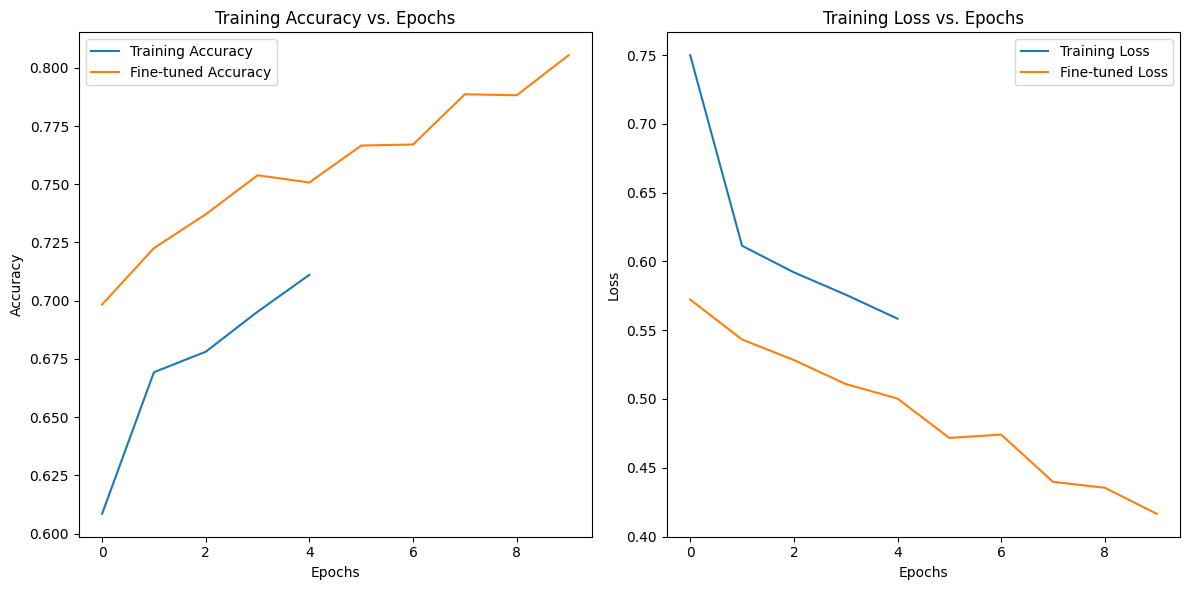

In [25]:
# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_acc:.2f}")

# Plot training loss and accuracy
plt.figure(figsize=(12, 6))

# Plot training accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history_fine_tune.history['accuracy'], label='Fine-tuned Accuracy')
plt.title('Training Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history_fine_tune.history['loss'], label='Fine-tuned Loss')
plt.title('Training Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 38s 4s/step


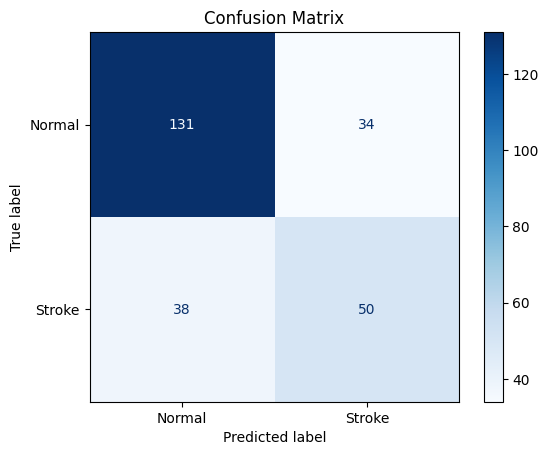

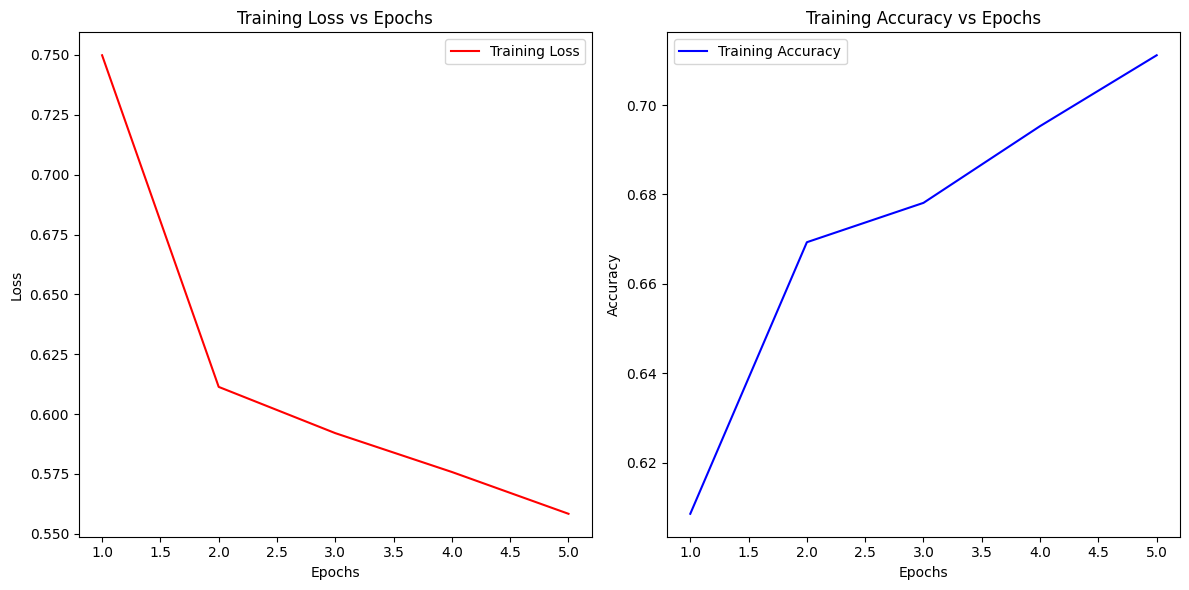

Results saved to 'results_metrics.xlsx'.


In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    ConfusionMatrixDisplay
)

# Evaluate the model on the test set
y_pred = (model.predict(x_test) > 0.5).astype(int)

# Metrics Calculation
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Stroke"]).plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# Training Metrics for Loss and Accuracy
training_loss = history.history['loss']
training_accuracy = history.history['accuracy']
epochs = range(1, len(training_loss) + 1)

# Plot Training Loss vs Accuracy
plt.figure(figsize=(12, 6))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, label='Training Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss vs Epochs')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracy, label='Training Accuracy', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy vs Epochs')
plt.legend()

plt.tight_layout()
plt.show()

# Save Metrics to Excel
results_data = {
    "Metric": ["Training Loss", "Accuracy", "Recall", "Precision", "F1 Score"],
    "Value": [
        training_loss[-1],  # Final training loss
        accuracy,
        recall,
        precision,
        f1
    ],
}

df_results = pd.DataFrame(results_data)
df_results.to_excel("/content/results_metrics.xlsx", index=False)

print("Results saved to 'results_metrics.xlsx'.")
